## Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance
from tqdm.notebook import tqdm

In [221]:
from scipy import optimize

In [440]:
start_date = "20130101"
end_date = "20131231"

AAPL = data.get_data_yahoo("AAPL", start_date, end_date)
XOM = data.get_data_yahoo("XOM", start_date, end_date)
PFE = data.get_data_yahoo("PFE", start_date, end_date)
GM = data.get_data_yahoo("GM", start_date, end_date)

asset1 = AAPL["Close"].to_numpy()
asset2 = XOM["Close"].to_numpy()
asset3 = PFE["Close"].to_numpy()
asset4 = GM["Close"].to_numpy()

# Risk free rate in 2020
Rf = data.get_data_yahoo("^TNX", start_date, end_date)
Rf_mean = Rf["Adj Close"].mean() / 100

In [441]:
AAPL

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2012-12-31  19.121429  18.178572  18.233213  19.006071  659492400.0  16.541199
2013-01-02  19.821428  19.343929  19.779285  19.608213  560518000.0  17.065252
2013-01-03  19.631071  19.321428  19.567142  19.360714  352965200.0  16.849854
2013-01-04  19.236786  18.779642  19.177500  18.821428  594333600.0  16.380499
2013-01-07  18.903570  18.400000  18.642857  18.710714  484156400.0  16.284145
...               ...        ...        ...        ...          ...        ...
2013-12-24  20.424286  20.215357  20.353214  20.273930  167554800.0  18.087893
2013-12-26  20.339287  20.120714  20.289286  20.139286  204008000.0  17.967758
2013-12-27  20.157499  19.982143  20.136429  20.003214  225884400.0  17.846359
2013-12-30  20.003214  19.725714  19.909286  19.804285  253629600.0  17.668886
2013-12-31  20.045713  19.785713  19.791786  20.036428  223084400.0  17.875999

[253 rows x 6 columns]

## Covariance Matrix $\Sigma$

In [469]:
assets_daily_return = [rateOfReturn(asset) for asset in [asset1, asset2, asset3, asset4]]
Sigma = np.cov(np.array(assets_daily_return), ddof=0)
Sigma

array([[ 3.22204119e-04,  8.69036250e-06, -1.53279481e-06,
         4.80279224e-05],
       [ 8.69036250e-06,  6.92622947e-05,  3.54908444e-05,
         5.02883692e-05],
       [-1.53279481e-06,  3.54908444e-05,  1.06401198e-04,
         5.34232253e-05],
       [ 4.80279224e-05,  5.02883692e-05,  5.34232253e-05,
         2.29666338e-04]])

In [471]:
R = np.mean(assets_daily_return,axis=1) * 254

## Portfolio weight

In [473]:
# Create the weights
def randomWeightGen(n=4):
    w = np.random.random(n)
    return w / w.sum()

def rateOfReturn(asset:np.array):
    return asset[1:] / asset[:-1] - 1

def portfolio(w:np.array, *assets):
    assert len(w) == len(assets)
    return np.dot(w, np.array(assets)) 


## Monte Carlo

In [474]:
x = []
y = []

for i in tqdm(range(30000)):
    asset = portfolio(randomWeightGen(4), asset1, asset2, asset3, asset4)
    x.append(np.std(rateOfReturn(asset)) * np.sqrt(254))
    y.append(np.mean(rateOfReturn(asset)) * 254)

In [475]:
# idx_max = np.argmax(list(map(lambda a: a[1]/a[0], zip(x,y))))
# x[idx_max], y[idx_max]

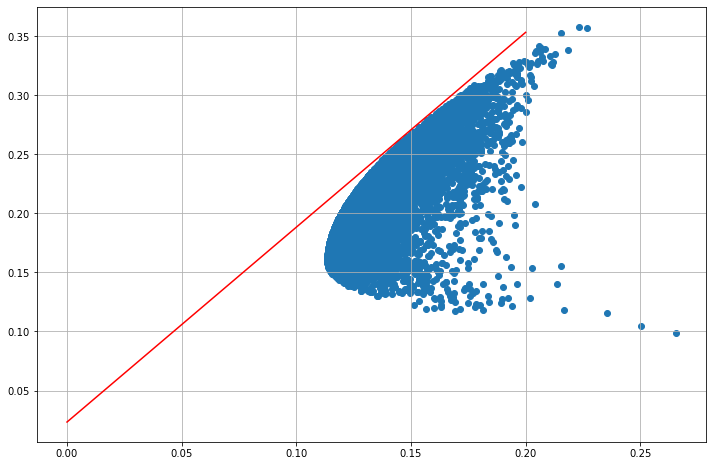

In [476]:
plt.figure(figsize=(12,8))
plt.grid()

plt.scatter(x, y)
a = np.linspace(0,0.2,100)
plt.plot(a, 1.65*a + Rf_mean, color="red")
plt.show()

## Analytical Solution to the Minimization problem
$$\begin{bmatrix}2\Sigma &-R & -{\bf1}\\ R^T &0 & 0 \\ {\bf1}^T &0 &0 \end{bmatrix} * \begin{bmatrix}w\\\lambda_1\\\lambda_2\end{bmatrix} = \begin{bmatrix}0\\\mu \\ 1\end{bmatrix}$$



In [491]:
n = 4
# The matrix on the left
mat1 = np.vstack(
    [
        np.hstack([2*Sigma, -np.expand_dims(R,axis=1), -np.ones((n,1))]),
        np.hstack([R, [0], [0]]),
        np.hstack([np.ones(n), [0], [0]])
    ]
)

arr_mu = np.linspace(0, 0.5, 1000)
arr_volatility = []
arr_w = []


for mu in arr_mu:
    # vec2 = np.array([0] * n + [mu] + [1])
    # # np.linalg.solve only solves n×n
    # w_lambda = np.linalg.lstsq(mat1, vec2)[0]

    vec2 = np.array([0] * n + [mu] + [1])
    w_lambda = np.linalg.solve(mat1, vec2)

    w = w_lambda[:n]
    arr_w.append(w)
    volatility = np.sqrt(np.dot(w, np.dot(Sigma, w))) * np.sqrt(254)
    arr_volatility.append(volatility)
arr_volatility = np.array([arr_volatility]).squeeze()

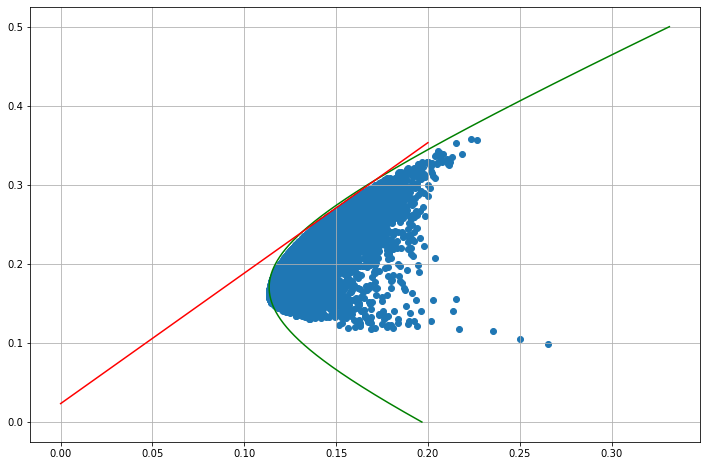

In [494]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(arr_volatility, arr_mu, color="green")

plt.scatter(x, y)
a = np.linspace(0,0.2,100)
plt.plot(a, 1.65*a + Rf_mean, color="red")
plt.savefig("Efficient Frontier.jpg")
plt.show()
